<a href="https://colab.research.google.com/github/rishubhkhurana/EVA/blob/master/S5/EVAS5v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Analysis -- Second Version

1. Target -- Reduce the Model capacity by descreasing the number of filters everywhere by sqrt(2) times. This will reduce the model capacity to be less than 10k params
2. Result -- Achieved Best Training Accuracy of 98.45 and Validation accuracy of 98.5 with ~9800 params
3. Analysis -- ~9.8K parameters. Not overfitting. Good sign. Need to push the model capacity now.

## Import Libs


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [0]:
!pip install torchsummary

In [0]:
from torchsummary import summary

## Transforms/Reading Dataset

In [0]:
train_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.ToTensor()])

In [0]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training Dataset Mean: 0.13054245710372925
Training Dataset Mean: 0.30810782313346863


In [0]:
print(f"Testing Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Testing Dataset Mean: 0.13054245710372925
Testing Dataset Mean: 0.3104802668094635


In [0]:
train_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1305,),(0.308,))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1305,),(0.308,))])

In [0]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)

In [0]:
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training Dataset Mean: 0.00167939648963511
Training Dataset Mean: 1.000349998474121


In [0]:
print(f"Testing Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Testing Dataset Mean: 0.00167939648963511
Testing Dataset Mean: 1.0080528259277344


## Defining Data Loader


In [0]:
# defining the seed for reproducible
SEED = 99

torch.manual_seed(SEED)

# checking if the CUDA is available 

is_CUDA = torch.cuda.is_available()

if is_CUDA:
  dev = torch.device('cuda')
else:
  dev = torch.device('cpu')



In [0]:
BATCH_SIZE=128
EPOCHS=15

In [0]:
dataloader_args = dict(shuffle=True,batch_size=BATCH_SIZE,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=True,batch_size=BATCH_SIZE//2)
train_dl = DataLoader(train_data,**dataloader_args)

dataloader_args = dict(shuffle=False,batch_size=BATCH_SIZE*2,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=False,batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data,**dataloader_args)

In [0]:
x,y=next(iter(train_dl))

In [0]:
x.size(),y.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [0]:
torch.Tensor.stats = lambda x: (x.mean(),x.std())

In [0]:
x.stats()

(tensor(0.0281), tensor(1.0290))

In [0]:
type(x)

torch.Tensor

## Visualizing the data

In [0]:
def plot_img(img,axs=None,figsize=(6,6),visible=True):
  if axs is None:
    _,axs=plt.subplots(1,1,figsize=figsize)
  if not visible:
    #print("yesy")
    axs.set_xticks([])
    axs.set_yticks([])
  axs.imshow(img.numpy().squeeze(0),cmap='gray_r')
  
  

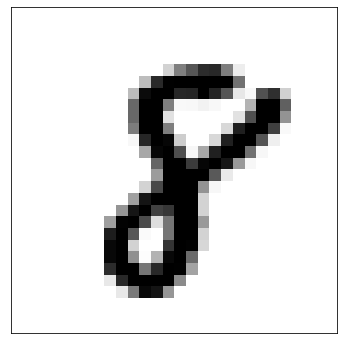

In [0]:
plot_img(x[0],visible=False)

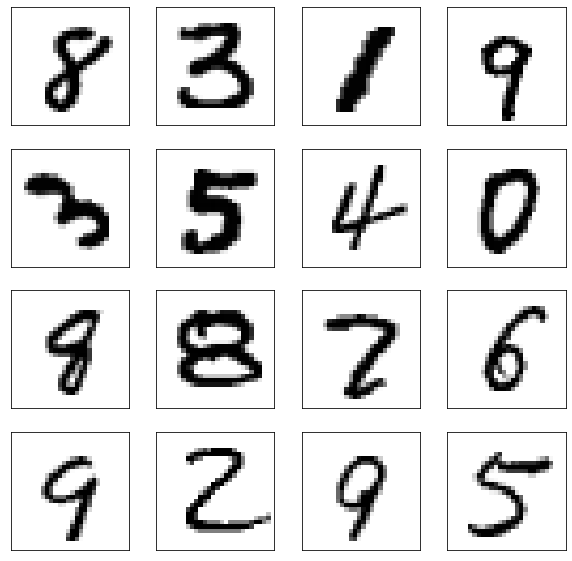

In [0]:
fig,axs = plt.subplots(4,4,figsize=(10,10))
for i,ax in enumerate(axs.ravel()):
  plot_img(x[i],axs=axs[i//4,i%4],visible=False)

## Defining Model

In [0]:
class Model(nn.Module):
  def __init__(self,p=0.0,use_bias=True):
    super().__init__()
    self.alllyrs=nn.Sequential()
    cblock1 = []
    cblock1.append(nn.Sequential(*[nn.Conv2d(1,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=26,RF=3
    cblock1.append(nn.Sequential(*[nn.Conv2d(12,24,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=24,RF=5
    self.cblock1 = nn.Sequential(*cblock1)
    tblock1=[]
    tblock1.append(nn.MaxPool2d((2,2))) # output_size=12, RF=6
    tblock1.append(nn.Sequential(*[nn.Conv2d(24,12,kernel_size=(1,1),stride=1,bias=use_bias),nn.ReLU()])) # output_size=12,RF=6
    self.tblock1=nn.Sequential(*tblock1)
    cblock2 = []
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=10,RF=10
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=8,RF=14
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=6,RF=18
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=4,RF=22
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.ReLU()])) # output_size=4,RF=26

    self.cblock2 = nn.Sequential(*cblock2)
    tblock2=[]
    tblock2.append(nn.AdaptiveAvgPool2d((1,1)))
    tblock2.append(nn.Conv2d(12,10,kernel_size=(1,1),stride=1))
    self.tblock2=nn.Sequential(*tblock2)
  def forward(self,x):
    x = self.cblock1(x)
    x = self.tblock1(x)
    x = self.cblock2(x)
    x = self.tblock2(x)
    return F.log_softmax(x).squeeze().squeeze()


In [0]:
mod=Model().cuda()

In [0]:
#mod

In [0]:
summary(model=mod,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
            Conv2d-3           [-1, 24, 24, 24]           2,616
              ReLU-4           [-1, 24, 24, 24]               0
         MaxPool2d-5           [-1, 24, 12, 12]               0
            Conv2d-6           [-1, 12, 12, 12]             300
              ReLU-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]           1,308
              ReLU-9           [-1, 12, 10, 10]               0
           Conv2d-10             [-1, 12, 8, 8]           1,308
             ReLU-11             [-1, 12, 8, 8]               0
           Conv2d-12             [-1, 12, 6, 6]           1,308
             ReLU-13             [-1, 12, 6, 6]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Training Loop Design

In [0]:
# basic loop structure

def one_epoch(model,trn_dl,val_dl,opt,device='cpu'):
  # variables to keep track off during one epoch
  bcount=0
  tlosses=0
  tacc=0
  # put model in training mode
  model.train()
  # define a progress bar
  pbar = tqdm(trn_dl)
  # loop through every batch in dataloader
  for batch_index,(xb,yb) in enumerate(pbar):
    # move the data to cpu or gpu based on device arg
    xb,yb=xb.to(device),yb.to(device)
    bs = xb.shape[0]
    # clean the gradients of parameters computed in the previous batch
    opt.zero_grad()
    # predict the batch
    preds = model(xb)
    # compute batch loss
    loss = F.nll_loss(preds,yb)
    # append the current loss to list
    tlosses+=loss*bs
    # call back propagation
    loss.backward()
    # call the optimization step
    opt.step()
    # compute the current model accuracy
    y_preds=preds.argmax(dim=1,keepdim=True)
    # compute current accuracy of the training batch and add it to the total count of accurate results
    tacc+= y_preds.eq(yb.view_as(y_preds)).sum().item()
    bcount+=bs
    # add progress bar description with current batch loss and moving average of training accuracy
    pbar.set_description(desc=f'Loss={loss.item():.3f} batch-index={batch_index} Accuracy={100*tacc/bcount:0.2f}')
  
  # compute the updated training loss and accuracy for entire batch
  tlosses/=bcount
  tacc/=bcount

  # loop through validation data and compute the metrics on validation data
  model.eval()
  vloss=0
  vacc=0
  vcount=0
  with torch.no_grad():
    for xb,yb in tqdm(val_dl):
      bs = xb.shape[0]
      xb,yb = xb.to(device),yb.to(device)
      preds = model(xb)
      loss = F.nll_loss(preds,yb,reduction='sum')
      y_preds = preds.argmax(dim=1,keepdim=True)
      vacc+=y_preds.eq(yb.view_as(y_preds)).sum().item()
      vcount+=bs
      vloss+=loss.item()
  vloss/=vcount
  vacc/=vcount
  return {'TrainingLoss':tlosses,'ValidationLoss':vloss,'TrainingAcc':tacc,'ValidationAcc':vacc}








## Training the Model

In [0]:
mod=Model().cuda()
opt = optim.SGD(mod.parameters(),lr=0.05,momentum=0.9)
for e in range(EPOCHS):
  ldict=one_epoch(mod,train_dl,test_dl,opt,device=dev)
  print(f'\nEpoch:{e}--> Training Loss:{ldict["TrainingLoss"]:.3f}, Validation Loss:{ldict["ValidationLoss"]:.3f}\n')
  print(f'Training Accuracy:{100*ldict["TrainingAcc"]:.3f}, Validation Accuracy:{100*ldict["ValidationAcc"]:.3f}\n')

  

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:0--> Training Loss:1.500, Validation Loss:0.220

Training Accuracy:44.748, Validation Accuracy:92.990



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.188, Validation Loss:0.105

Training Accuracy:94.322, Validation Accuracy:96.720



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.112, Validation Loss:0.100

Training Accuracy:96.633, Validation Accuracy:96.920



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.095, Validation Loss:0.081

Training Accuracy:97.063, Validation Accuracy:97.410



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.087, Validation Loss:0.076

Training Accuracy:97.377, Validation Accuracy:97.760



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:5--> Training Loss:0.078, Validation Loss:0.085

Training Accuracy:97.652, Validation Accuracy:97.610



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.070, Validation Loss:0.063

Training Accuracy:97.925, Validation Accuracy:98.140



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.072, Validation Loss:0.078

Training Accuracy:97.813, Validation Accuracy:97.730



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.063, Validation Loss:0.060

Training Accuracy:98.110, Validation Accuracy:98.280



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.060, Validation Loss:0.059

Training Accuracy:98.202, Validation Accuracy:98.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:10--> Training Loss:0.059, Validation Loss:0.062

Training Accuracy:98.225, Validation Accuracy:98.120



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.061, Validation Loss:0.066

Training Accuracy:98.163, Validation Accuracy:97.980



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.054, Validation Loss:0.065

Training Accuracy:98.413, Validation Accuracy:98.220



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.052, Validation Loss:0.049

Training Accuracy:98.455, Validation Accuracy:98.500



100%|██████████| 40/40 [00:01<00:00, 25.37it/s]


Epoch:14--> Training Loss:0.050, Validation Loss:0.063

Training Accuracy:98.472, Validation Accuracy:98.200

